## Imports

In [1]:
# The OS module in Python provides functions for interacting with the operating system
import os

import itertools

# import the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tsa statsmodel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# FB Prophet
#!pip install pystan
#!pip install prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot

### Load the (untransformed) data

In [2]:
path1 = 'C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_untransformed.csv'

df = pd.read_csv(path1, parse_dates=['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    509 non-null    datetime64[ns]
 1   AQI     509 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.1 KB


In [4]:
df.head()

,Date,AQI
0,1980-01-31,34.0
1,1980-02-29,38.0
2,1980-03-31,39.0
3,1980-04-30,44.0
4,1980-05-31,50.0


In [5]:
# set index to Date
df.set_index('Date', inplace=True)

# data must have columns ds and y for prophet to work
ts = pd.DataFrame({'ds': df.index, 'y': df.AQI})

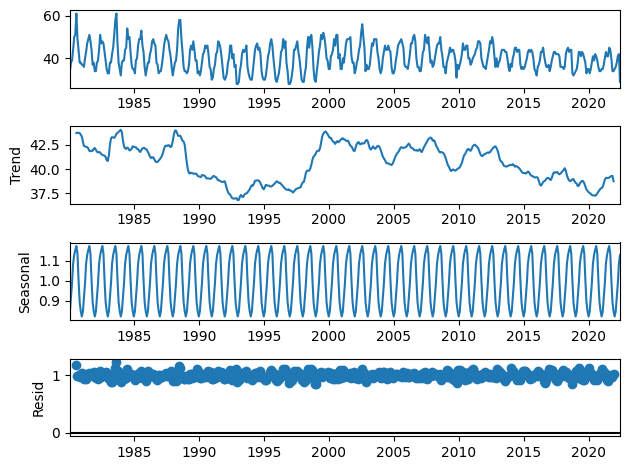

In [6]:
# decomposition of ts from statsmodel

components = seasonal_decompose(df, model='multiplicative')
components.plot()
plt.show()

### Prophet
create train and test sets

In [7]:
# goal: forecast the AQI for the next 12 months.
# remove the last 12 rows as our test set

#ts.tail(12)

# drop last 12 columns
ts_present = ts.iloc[:len(ts)-12]
#ts_present.tail()

ts_test = ts.iloc[len(ts)-12: len(ts)]
ts_test

,ds,y
Date,,
2021-06-30,2021-06-30,41.0
2021-07-31,2021-07-31,45.0
2021-08-31,2021-08-31,44.0
2021-09-30,2021-09-30,40.0
2021-10-31,2021-10-31,34.0
2021-11-30,2021-11-30,34.0
2021-12-31,2021-12-31,35.0
2022-01-31,2022-01-31,36.0
2022-02-28,2022-02-28,38.0


In [8]:
# Run a basic Prophet model
# instantiate the model and fit the timeseries

prophet = Prophet() # allow Prophet to automatically chose the hyperparameters
prophet.fit(ts_present)

# create a FUTURE date frame
future = prophet.make_future_dataframe(periods=12, freq = 'M')
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()



22:21:35 - cmdstanpy - INFO - Chain [1] start processing
22:21:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1980-01-31,37.167967,33.896223,40.327277
1,1980-02-29,39.980443,36.703310,43.455525
2,1980-03-31,42.499126,39.041502,45.847895
3,1980-04-30,46.733753,43.555343,50.150150
4,1980-05-31,48.975562,45.612056,52.403332


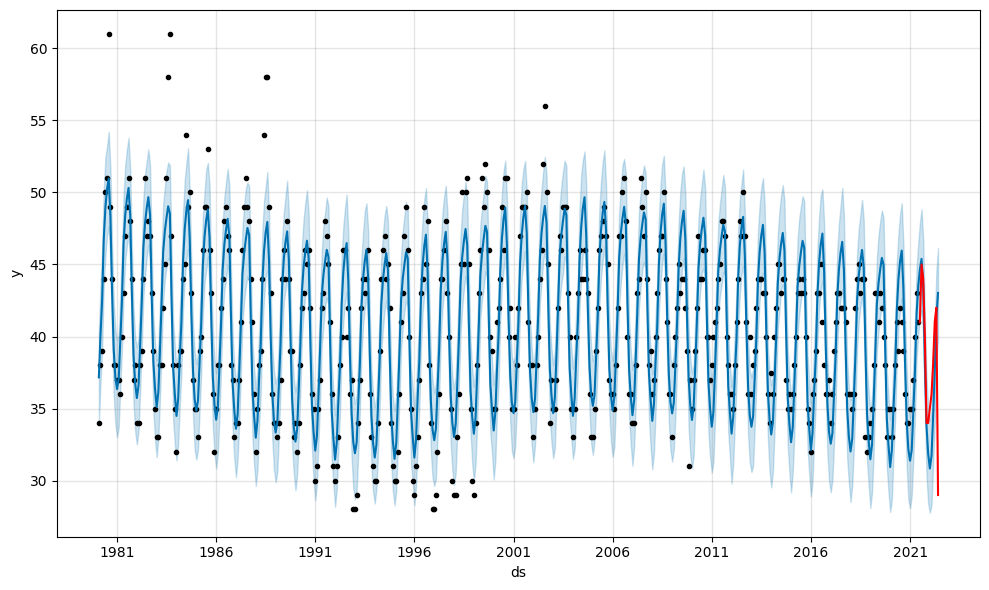

In [26]:
# plot
fig = prophet.plot(forecast)
plt.plot(ts_test.ds, ts_test.y, color='r')

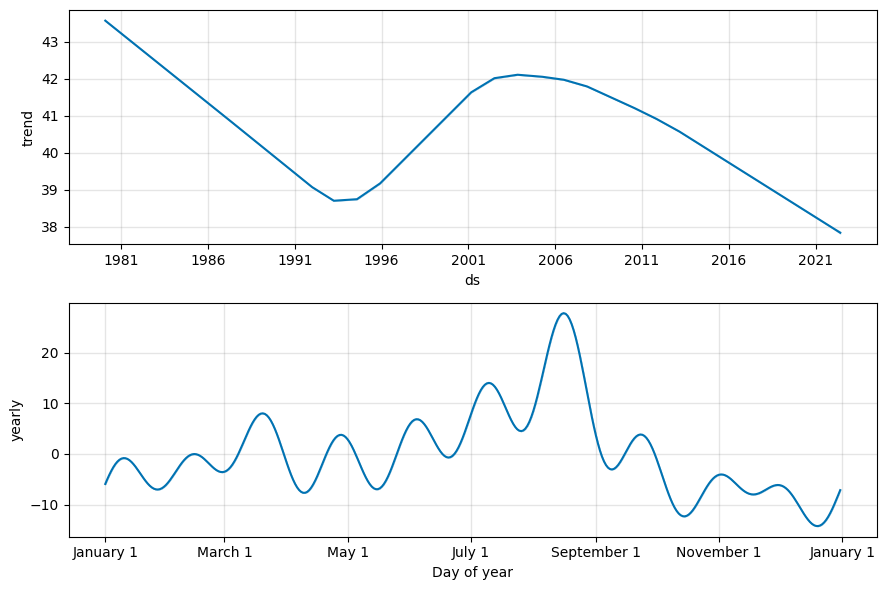

In [10]:
fig = prophet.plot_components(forecast)

Highest median AQI levels occur in the end of August.

<AxesSubplot: xlabel='ds'>

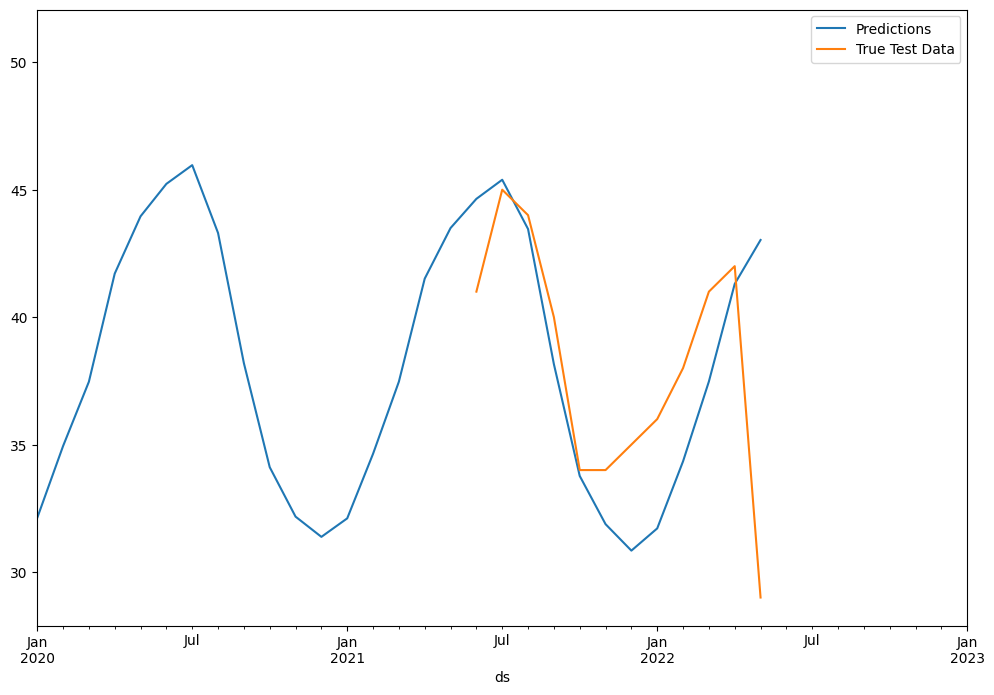

In [11]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,8))
ts_test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2020-01-01', '2023-01-01'))

In [12]:
# ts_test (actual values) vs forecast (predicted) dataframes
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
504,2022-01-31,31.711893,28.321284,34.814490
505,2022-02-28,34.344056,31.093424,37.645755
506,2022-03-31,37.474705,33.927480,40.581905
507,2022-04-30,41.303827,38.254792,44.506793
508,2022-05-31,43.027031,39.861509,46.147759


In [13]:
ts_test.tail()

,ds,y
Date,,
2022-01-31,2022-01-31,36.0
2022-02-28,2022-02-28,38.0
2022-03-31,2022-03-31,41.0
2022-04-30,2022-04-30,42.0
2022-05-31,2022-05-31,29.0


## Cross Validation and Hyperparameter Tuning (untransformed data)


In [15]:
# https://medium.com/swlh/facebook-prophet-426421f7e331

In [16]:
#https://stackoverflow.com/questions/66278305/how-to-choose-initial-period-horizon-and-cutoffs-with-facebook-prophet
# how to choose horizon, cutoff...etc

In [17]:
#https://facebook.github.io/prophet/docs/diagnostics.html
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    #'seasonality_mode': ['additive', 'multiplicative']
} 


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters

for params in all_params:
    
    initial = '10957.5 days' #30 years
    horizon = '360 days' #predict the next year
    period = '90 days' #run the model every 90 days
    
    m = Prophet(**params).fit(ts_present)  # Fit model with given params
    df_cv = cross_validation(m, initial = initial , horizon=horizon, period = period, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=30)
    rmses.append(df_p['rmse'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mapes
print(tuning_results)

22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:02 - cmdstanpy - INFO - Chain [1] start processing
22:22:02 - cmdstanpy - INFO - Chain [1] done processing
22:22:26 - cmdstanpy - INFO - Chain [1] start processing
22:22:26 - cmdstanpy - INFO - Chain [1] done processing
22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:50 - cmdstanpy - INFO - Chain [1] done processing
22:23:14 - cmdstanpy - INFO - Chain [1] start processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing
22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:36 - cmdstanpy - INFO - Chain [1] done processing
22:23:58 - cmdstanpy - INFO - Chain [1] start processing
22:23:58 - cmdstanpy - INFO - Chain [1] done processing
22:24:19 - cmdstanpy - INFO - Chain [1] start processing
22:24:19 - cmdstanpy - INFO - Chain [1] done processing
22:24:42 - cmdstanpy - INFO - Chain [1] start processing
22:24:42 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse      mape
0                     0.001                     0.01  3.242243  0.063340
1                     0.001                     0.10  3.541491  0.069494
2                     0.001                     1.00  3.577539  0.070157
3                     0.001                    10.00  3.539035  0.069710
4                     0.050                     0.01  2.706533  0.054722
5                     0.050                     0.10  2.987313  0.060835
6                     0.050                     1.00  2.997380  0.060944
7                     0.050                    10.00  2.995609  0.060901
8                     0.100                     0.01  2.681297  0.054552
9                     0.100                     0.10  2.956079  0.060885
10                    0.100                     1.00  2.963841  0.060960
11                    0.100                    10.00  2.961741  0.060914
12                    0.500                     0.0

In [18]:
tuning_results.sort_values(by=['rmse', 'mape'])

,changepoint_prior_scale,seasonality_prior_scale,rmse,mape
12,0.500,0.01,2.677025,0.054845
8,0.100,0.01,2.681297,0.054552
4,0.050,0.01,2.706533,0.054722
13,0.500,0.10,2.938613,0.061113
15,0.500,10.00,2.944643,0.061245
14,0.500,1.00,2.946591,0.061277
9,0.100,0.10,2.956079,0.060885
11,0.100,10.00,2.961741,0.060914
10,0.100,1.00,2.963841,0.060960
5,0.050,0.10,2.987313,0.060835


In [19]:
best_params_rmse = all_params[np.argmin(rmses)]
print('Best params by RMSE: ')
print(best_params_rmse)


best_params_mape = all_params[np.argmin(mapes)]
print('Best params by MAPE: ')
print(best_params_mape)


Best params by RMSE: 
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Best params by MAPE: 
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


Use the model with the better RMSE. Some values in the time series may take 0 values, so it doesn't make sense to base it on MAPE.

## Modelling (untransformed data)

### Model 1:
changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01

In [20]:
# best model 1
m1 = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01)
m1.fit(ts_present)

# create a FUTURE date frame for m1; periods = 12
future1 = m1.make_future_dataframe(periods=12, freq = 'M')
forecast1 = m1.predict(future1)

# display the most critical output columns from the forecast
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

22:27:46 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1980-01-31,36.868516,33.602160,40.210169
1,1980-02-29,39.448134,36.439325,42.698982
2,1980-03-31,42.179321,38.932026,45.486885
3,1980-04-30,45.879288,42.627153,49.415045
4,1980-05-31,47.617478,44.497023,50.902422


  0%|          | 0/76 [00:00<?, ?it/s]

22:27:47 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:49 - cmdstanpy - INFO - Chain [1] done processing
22:27:50 - cmdstanpy - INFO - Chain [1] start processing
22:27:51 - cmdstanpy - INFO - Chain [1] done processing
22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:52 - cmdstanpy - INFO - Chain [1] done processing
22:27:53 - cmdstanpy - INFO - Chain [1] start processing
22:27:54 - cmdstanpy - INFO - Chain [1] done processing
22:27:54 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing
22:27:56 - cmdstanpy - INFO - Chain [1] start processing
22:27:57 - cmdstanpy - INFO - Chain [1] done processing
22:27:57 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:00 - cmdstanpy - INFO - Chain [1]

22:28:46 - cmdstanpy - INFO - Chain [1] done processing
22:28:47 - cmdstanpy - INFO - Chain [1] start processing
22:28:47 - cmdstanpy - INFO - Chain [1] done processing
22:28:48 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing
22:28:49 - cmdstanpy - INFO - Chain [1] start processing
22:28:49 - cmdstanpy - INFO - Chain [1] done processing


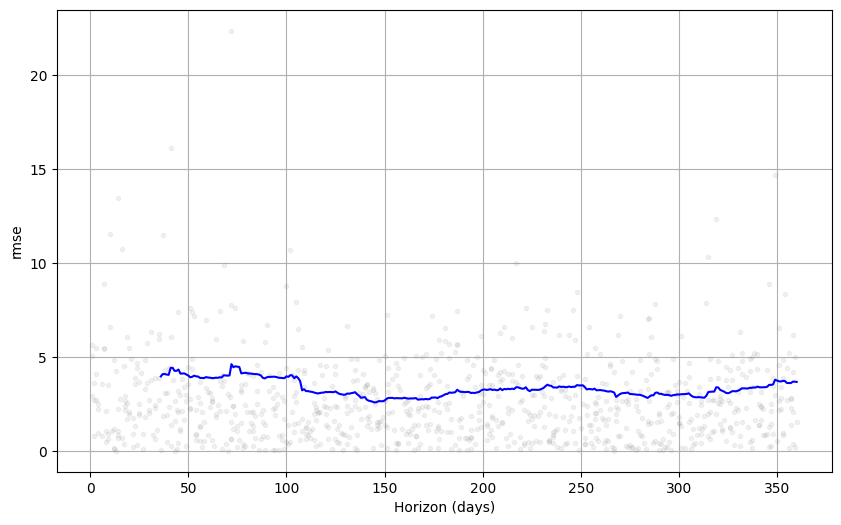

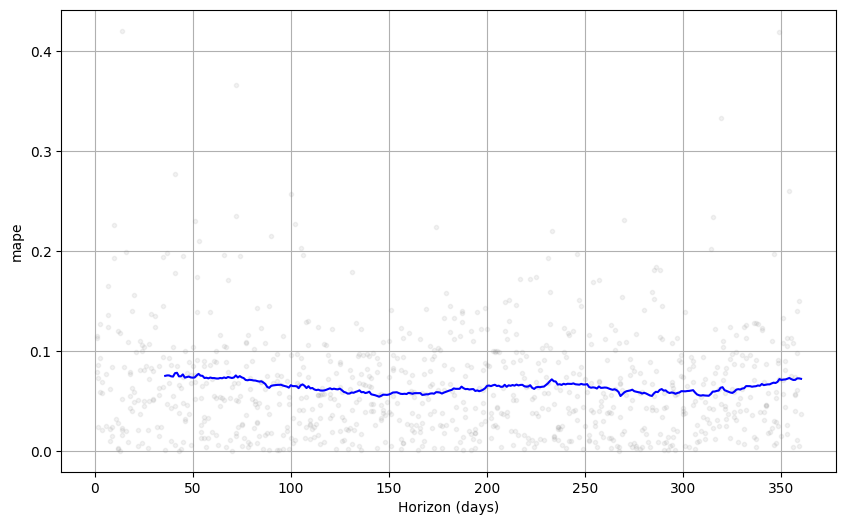

In [21]:
# performance metrics on best model
ts_cv1 = cross_validation(m1, horizon = '360 days')
fig1_rsme = plot_cross_validation_metric(ts_cv1, metric = 'rmse')
fig1_mape = plot_cross_validation_metric(ts_cv1, metric = 'mape')

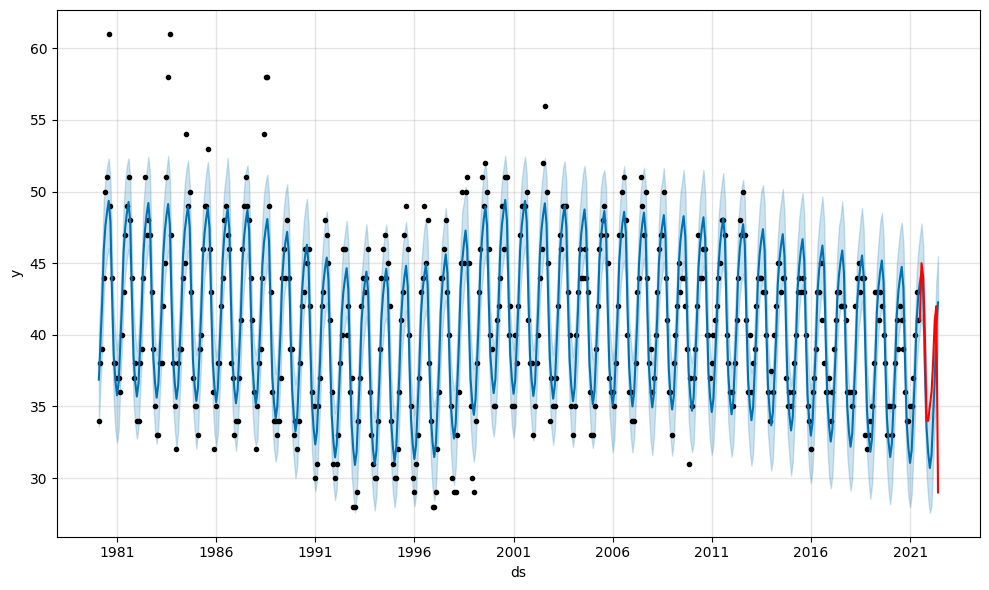

In [22]:
# plot
fig1 = m1.plot(forecast1)
plt.plot(ts_test.ds, ts_test.y, color='r') # plot actual values in red

<AxesSubplot: xlabel='ds'>

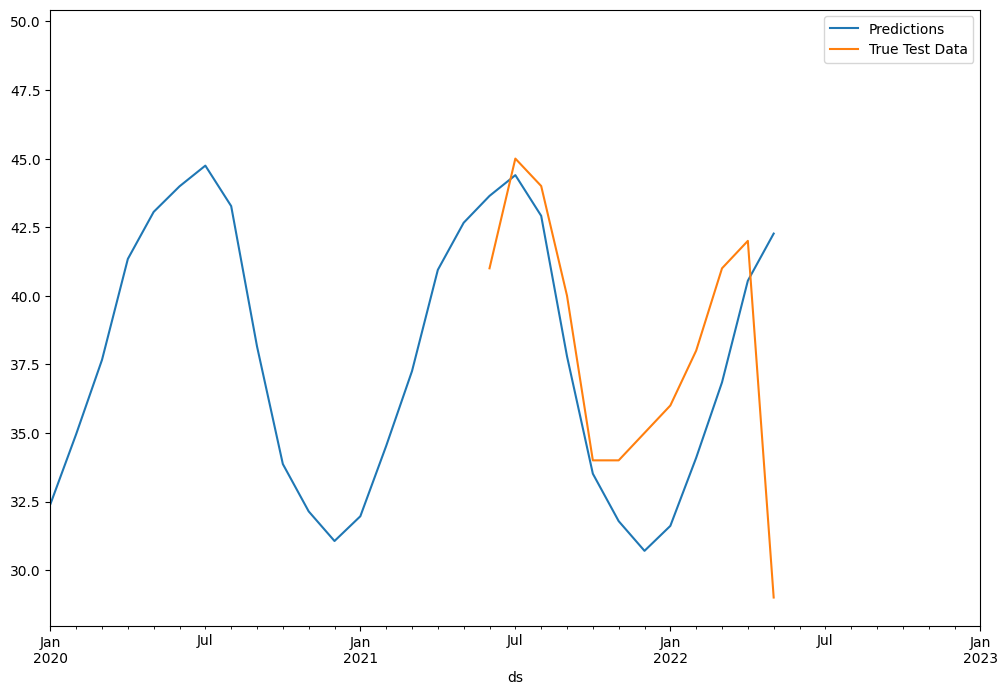

In [23]:
# zoomed in plot of the forecast

ax = forecast1.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,8))
ts_test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2020-01-01', '2023-01-01'))

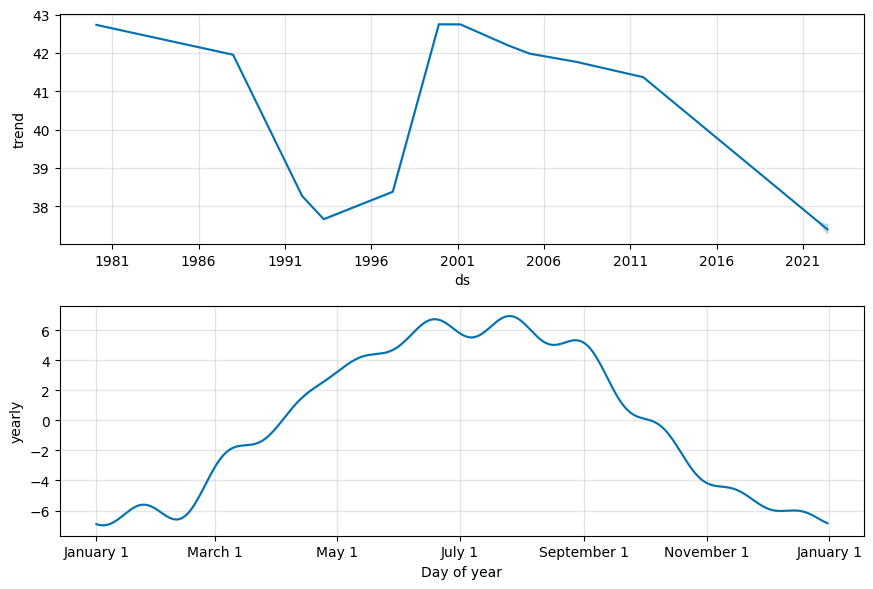

In [24]:
# components
fig1_comp = m1.plot_components(forecast1)

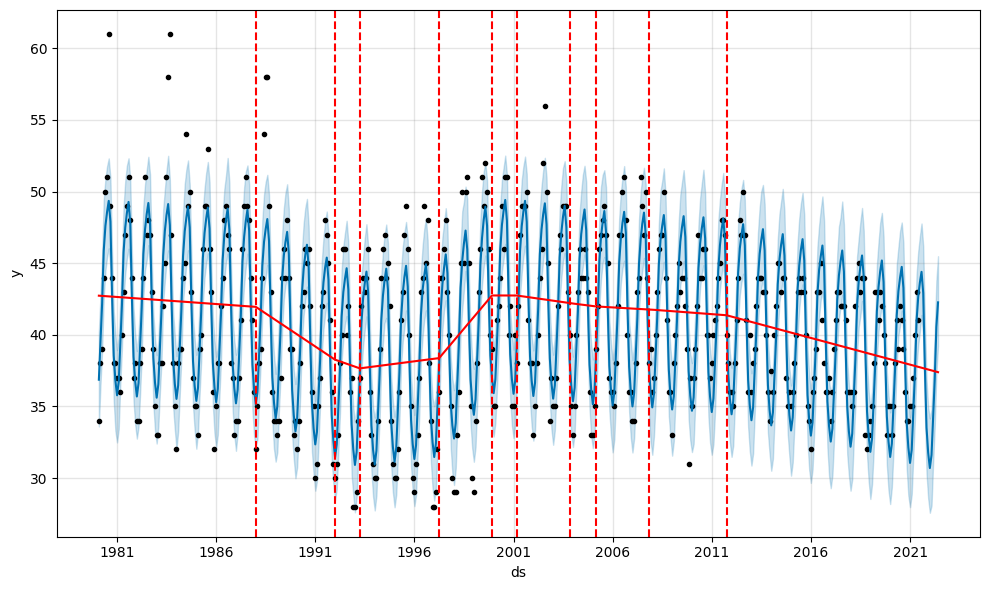

In [25]:
#https://www.geeksforgeeks.org/time-series-analysis-using-facebook-prophet/

# Add changepoints to indicate the time in rapid trend growths. 
# The dotted red lines show the time when there was a rapid change in the trend of AQI.

fig1 = m1.plot(forecast1)
a1 = add_changepoints_to_plot(fig1.gca(), m1, forecast1)